# Data Analysis Project

## Summary
A complete description of the project can be found below. The cost of living data set can be accessed in the [project's GitHub repository]().

## Motivation

My primary motivation for this project was to practice using the skills and tools listed below. Secondarily, I wanted to learn more about the cost of living in other countries.

## Skills and Tools Used

### Skills

- Data analysis
- Data visualization
- Statistics
- Data cleaning
- Project documentation

### Tools

- Python
    - pandas
    - Matplotlib
    - NumPy
    - GeoPandas
    - GeoPy
- Tableau
- Jupyter Notebook

## Data Preparation

### Questions to Answer

I started by formulating the questions that I wanted to answer through my analysis. These questions are listed below.

1. How does the cost of living in Seattle compare to other cities around the world?
2. How does the cost of living in the US compare to other countries around the world?
3. What are the most uniformly priced goods and services?
4. Which goods and services are the most correlated in price?

### Data Requirements Specification

I then specified the requirements for the data set I would analyze to answer my questions. These requirements are listed below.

*The data set must:*

- contain data for numerous cities around the world
- contain the prices for a variety of common goods and services
- be relatively clean and easy to work with
- be free and publicly accessible
- be in a standard format (such as a CSV file)

### Data Set Selection

Next, I began looking for a data set that met my requirements. Eventually, I settled on a [data set](https://www.kaggle.com/stephenofarrell/cost-of-living) uploaded to Kaggle, an online community of data scientists, by user Stephen Farrell. This data set was scraped from publicly accessible data on [Numbeo](https://www.numbeo.com/cost-of-living/), a crowd-sourced database of reported consumer prices and other statistics.

### Understanding the Data Set

I then examined the data set to understand its contents.

In [1]:
# Import package used for data analysis and manipulation in Python
import pandas

# Import the data set (as a CSV file) into a pandas DataFrame
raw_data = pandas.read_csv('cost_of_living.csv', index_col = 0)

# Print the dimensions of the DataFrame, check for missing values, and display the first five rows and columns
print("Number of rows: ", raw_data.shape[0], "\nNumber of columns: ", raw_data.shape[1])
print("Contains missing values:", raw_data.isnull().values.any())
print("First five rows and columns:")
raw_data.iloc[:5,:5]

Number of rows:  55 
Number of columns:  160
Contains missing values: False
First five rows and columns:


,"Saint Petersburg, Russia","Istanbul, Turkey","Izmir, Turkey","Helsinki, Finland","Chisinau, Moldova"
"Meal, Inexpensive Restaurant",7.34,4.58,3.06,12.00,4.67
"Meal for 2 People, Mid-range Restaurant, Three-course",29.35,15.28,12.22,65.00,20.74
McMeal at McDonalds (or Equivalent Combo Meal),4.40,3.82,3.06,8.00,4.15
Domestic Beer (0.5 liter draught),2.20,3.06,2.29,6.50,1.04
Imported Beer (0.33 liter bottle),2.20,3.06,2.75,6.75,1.43


The data set contains 55 rows corresponding to various common goods and services and 160 columns corresponding to various cities around the world. The data set does not contain missing values and each entry is a price specified to two decimal places. The currency for the prices was not specified but after examining the Numbeo website, it was clear that the prices were in Euros.

*A few of the items, such as mortgage interest rate, do not correspond to a good or service. However, for simplicity, all 55 items will be referred to as "goods and services" throughout this analysis.*

### Data Cleaning

To facilitate analysis of the data set, I specified the following data cleaning actions:

1. Transpose the data set so that the column attributes become the row attributes and the row attributes become the column attributes.
2. Convert the prices from Euros to US Dollars.
3. Instead of one column attribute for the combined city, state (for US cities), and country, segment this information into three separate columns. For cities without a specified state, set the "State" attribute to None.
4. Obtain the latitude and longitude of each city.

The first three data cleaning actions are performed below.

In [2]:
# 1) Transpose the DataFrame (switch the rows and columns)
transposed = raw_data.transpose()

# 2) Convert the prices from Euro to USD
prices = transposed.multiply(1.10).round(decimals = 2)

# 3) Add three columns for the city name, state name, and country name of each city
geo_info = prices.index.to_series().str.split(',', expand = True)
for row in range(len(geo_info)):
    if geo_info.iloc[row][2] is None:
        geo_info.iloc[row][2] = geo_info.iloc[row][1]
        geo_info.iloc[row][1] = None

prices.insert(0,'City', geo_info.iloc[:,0].str.strip())
prices.insert(1,'State', geo_info.iloc[:,1].str.strip())
prices.insert(2,'Country', geo_info.iloc[:,2].str.strip())
prices.index = range(len(prices))


print("First five rows and columns:")
prices.iloc[:5,:5]

First five rows and columns:


,City,State,Country,"Meal, Inexpensive Restaurant","Meal for 2 People, Mid-range Restaurant, Three-course"
0,Saint Petersburg,None,Russia,8.07,32.29
1,Istanbul,None,Turkey,5.04,16.81
2,Izmir,None,Turkey,3.37,13.44
3,Helsinki,None,Finland,13.20,71.50
4,Chisinau,None,Moldova,5.14,22.81


To complete the fourth data cleaning action, I used the GeoPy package to request the latitude and longitude of each city from Nominatim, a geocoding service. To avoid having to request this data more than once, I saved this information in a CSV file named "lat_long.csv".

In [3]:
# 4) Obtain the latitude and longitude of each city

# Import the package used to obtain the latitude and longitude of each city 
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Z")

# Initialize the lists used to store the latitudes and longitudes
latitudes = []
longitudes = []

# Obtain and store the latitude and longitude of each city
for row in range(len(prices)):
    location = geolocator.geocode(prices.iloc[row]['City'] + ", " + prices.iloc[row]['Country'])
    latitudes.append(location.latitude)
    longitudes.append(location.longitude)

# Write the latitudes and longitudes to a CSV file for later use
lat_long = pandas.DataFrame({'Latitude': latitudes, 'Longitude': longitudes})
lat_long.to_csv('lat_long.csv', index=False)

## Data Analysis in Python

### Data Exploration


Before attempting to answer my questions, I first explored the data to spot any noteworthy patterns or features.

I started by visualizing the distribution of mean prices for the 55 listed goods and services. 

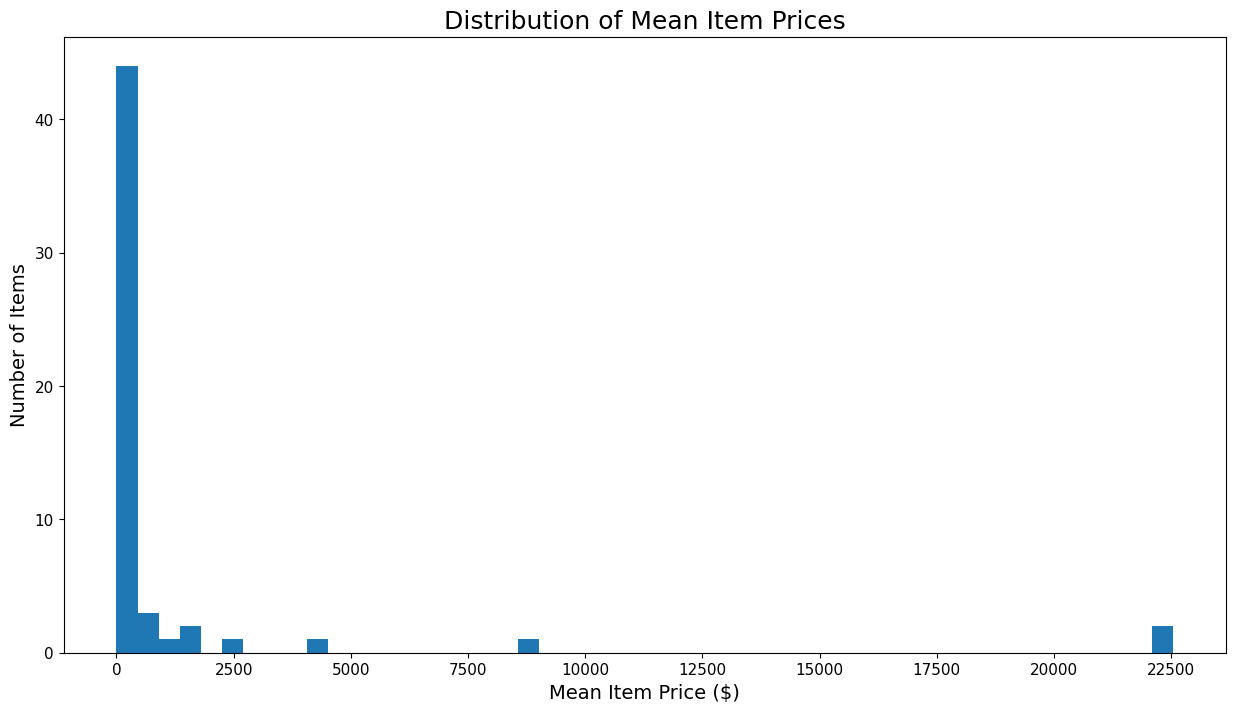

In [4]:
# Import package used for creating data visualizations
import matplotlib.pyplot as plt

# Create a histogram using the mean price of each item
plt.figure(figsize=(15,8))
plt.hist(prices.iloc[:,3:].mean(axis = 0), bins = 50)
plt.xticks(range(0,25000,2500), fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel('Mean Item Price ($)', fontsize=14)
plt.ylabel('Number of Items', fontsize=14)
plt.title('Distribution of Mean Item Prices', fontsize=18)
plt.show()

From the histogram above, it is clear that the vast majority of the goods and services are relatively inexpensive, representing low-budget items that can be purchased by most people. However, certain items, such as a new car, are significantly more expensive and indicate the cost of living for a middle class lifestyle.

I then used a box and whisker plot to compare the cost of living in the 160 listed cities, using the comparison metric described below.

**Cost of living metric:** I used the median price of all 55 items as the cost of living metric for each city. I used the median price rather than the mean price to eliminate the effect of high priced items, such as a new car, which disproportionately affect the mean price. This analysis was primarily performed from the perspective of a budget-conscious tourist who will mostly purchase low-cost items, so I wanted relatively inexpensive items like restaurant meals to be heavily weighted in the cost of living metric. The median gives each item equal weight and as the majority of the items are inexpensive, the median price serves as a good indicator of the cost of living for a tourist. There are more sophisticated ways to measure cost of living but the median serves as a simple yet insightful metric for this data set.

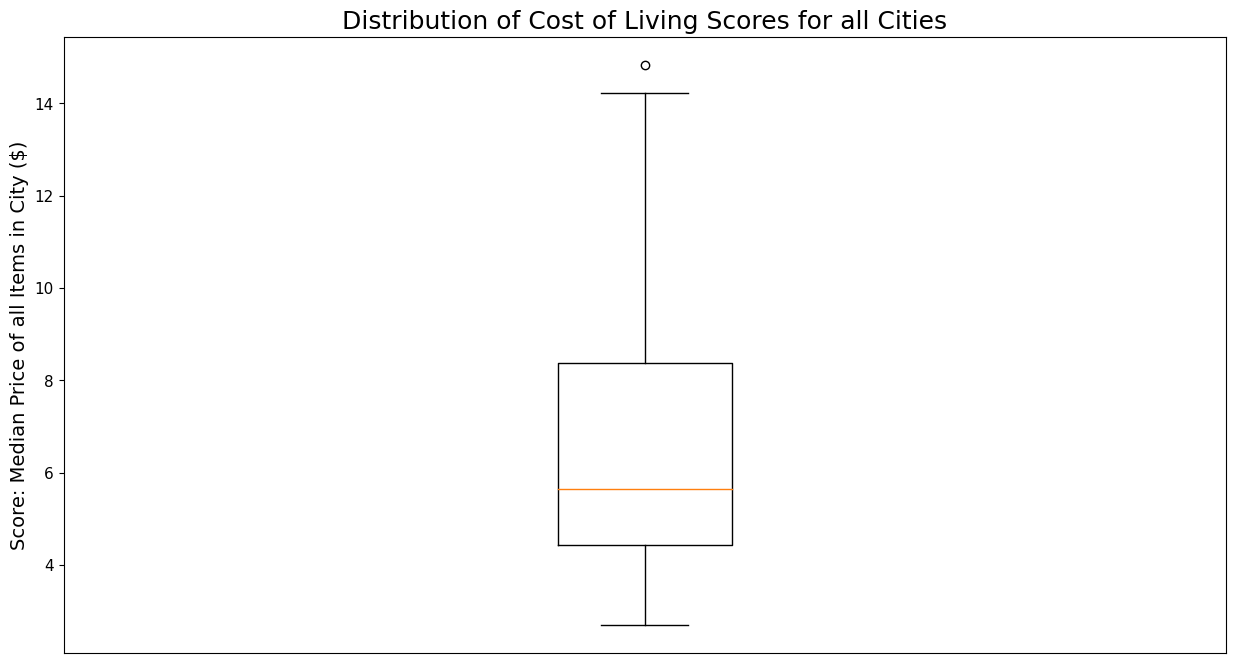

In [5]:
# Create a box and whisker plot using the median item price in each city
plt.figure(figsize=(15,8))
plt.boxplot(prices.iloc[:,3:].median(axis = 1))
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.yticks(fontsize=11)
plt.ylabel('Score: Median Price of all Items in City ($)', fontsize=14)
plt.title('Distribution of Cost of Living Scores for all Cities', fontsize=18)
plt.show()

The box plot above suggests that most of the cities in the data set have a fairly comparable cost of living, but there are some cities with a significantly higher cost of living. 

Finally, I plotted each city on a world map to determine which geographic regions were most widely represented in the data set.  

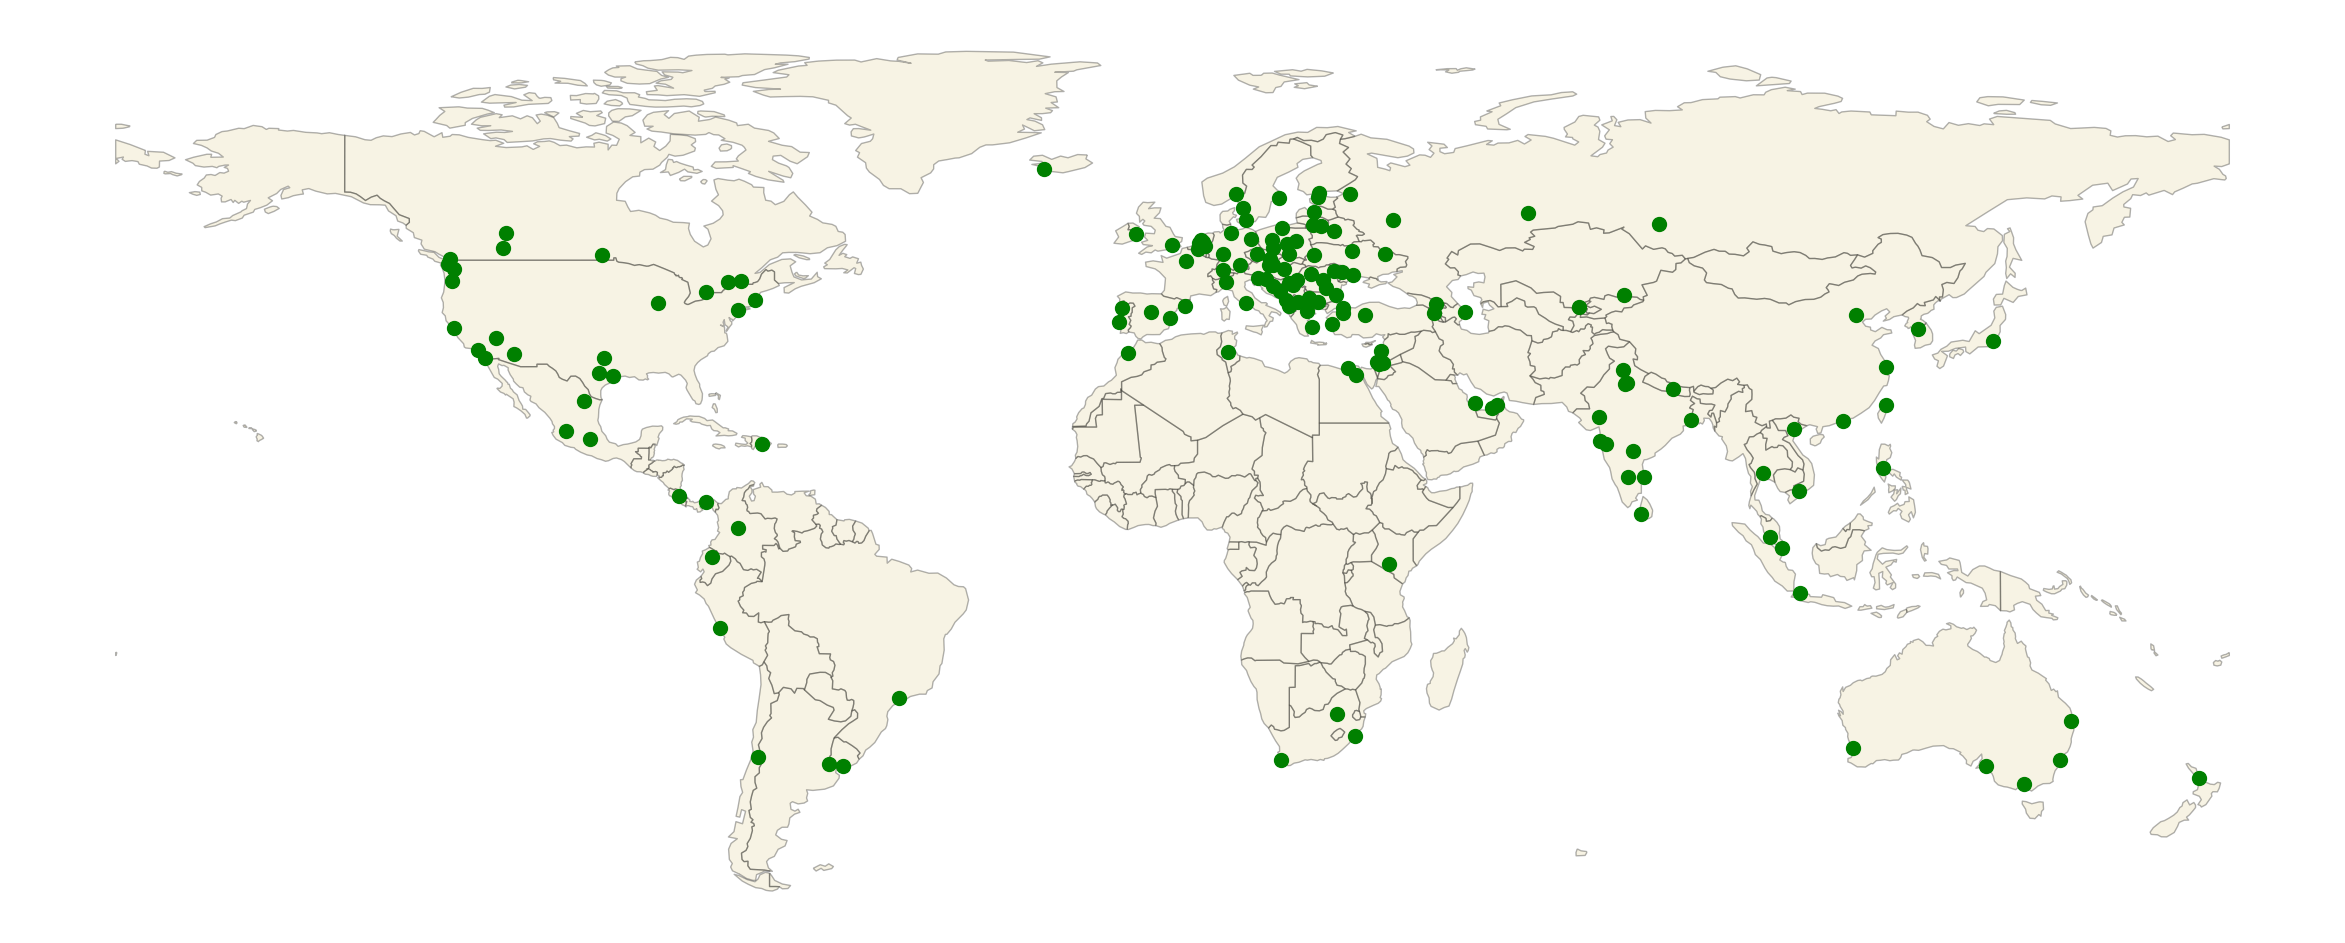

In [6]:
# Import packages necessary for plotting geographic data
import geopandas
from shapely.geometry import Point

# Read the CSV file containing each city's latitude and longitude
lat_long = pandas.read_csv('lat_long.csv')

# Use the latitudes and longitudes to create a list of shapely Point objects to be passed into geopandas
geometry = [Point(xy) for xy in zip(lat_long['Longitude'], lat_long['Latitude'])]

# Load the world map from geopandas and exclude Antarctica
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[world.name!="Antarctica"]

# Create a GeoDataFrame using the prices DataFrame and the list of Point objects, geometry
geo_df = geopandas.GeoDataFrame(prices, crs = world.crs, geometry = geometry)

# Plot the city locations on the world map
base = world.plot(color='xkcd:beige', alpha=0.3, edgecolor='black', figsize=(30, 20))
base.set_axis_off()
geo_df.plot(ax=base, marker='o', color='green', markersize=100)
plt.show()

The dot map above indicates that most of the cities in the data set are located in Europe, some of the cities are located in North America and Asia, and only a few of the cities are located in the rest of the world.

### Question 1: How does the cost of living in Seattle compare to other cities around the world?

Having gotten a general sense of the data, I then attempted to answer my first question.

To compare Seattle to the other cities in the data set, I used the cost of living metric described above, the median price of all 55 goods and services. The bubble map below portrays each city's cost of living, with a larger bubble indicating a higher cost of living.

/var/folders/pl/n9dpnr6j189_tc7zv1jcdnph0000gn/T/ipykernel_17343/598625597.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  median_prices = prices.iloc[:,3:].median(axis = 1)


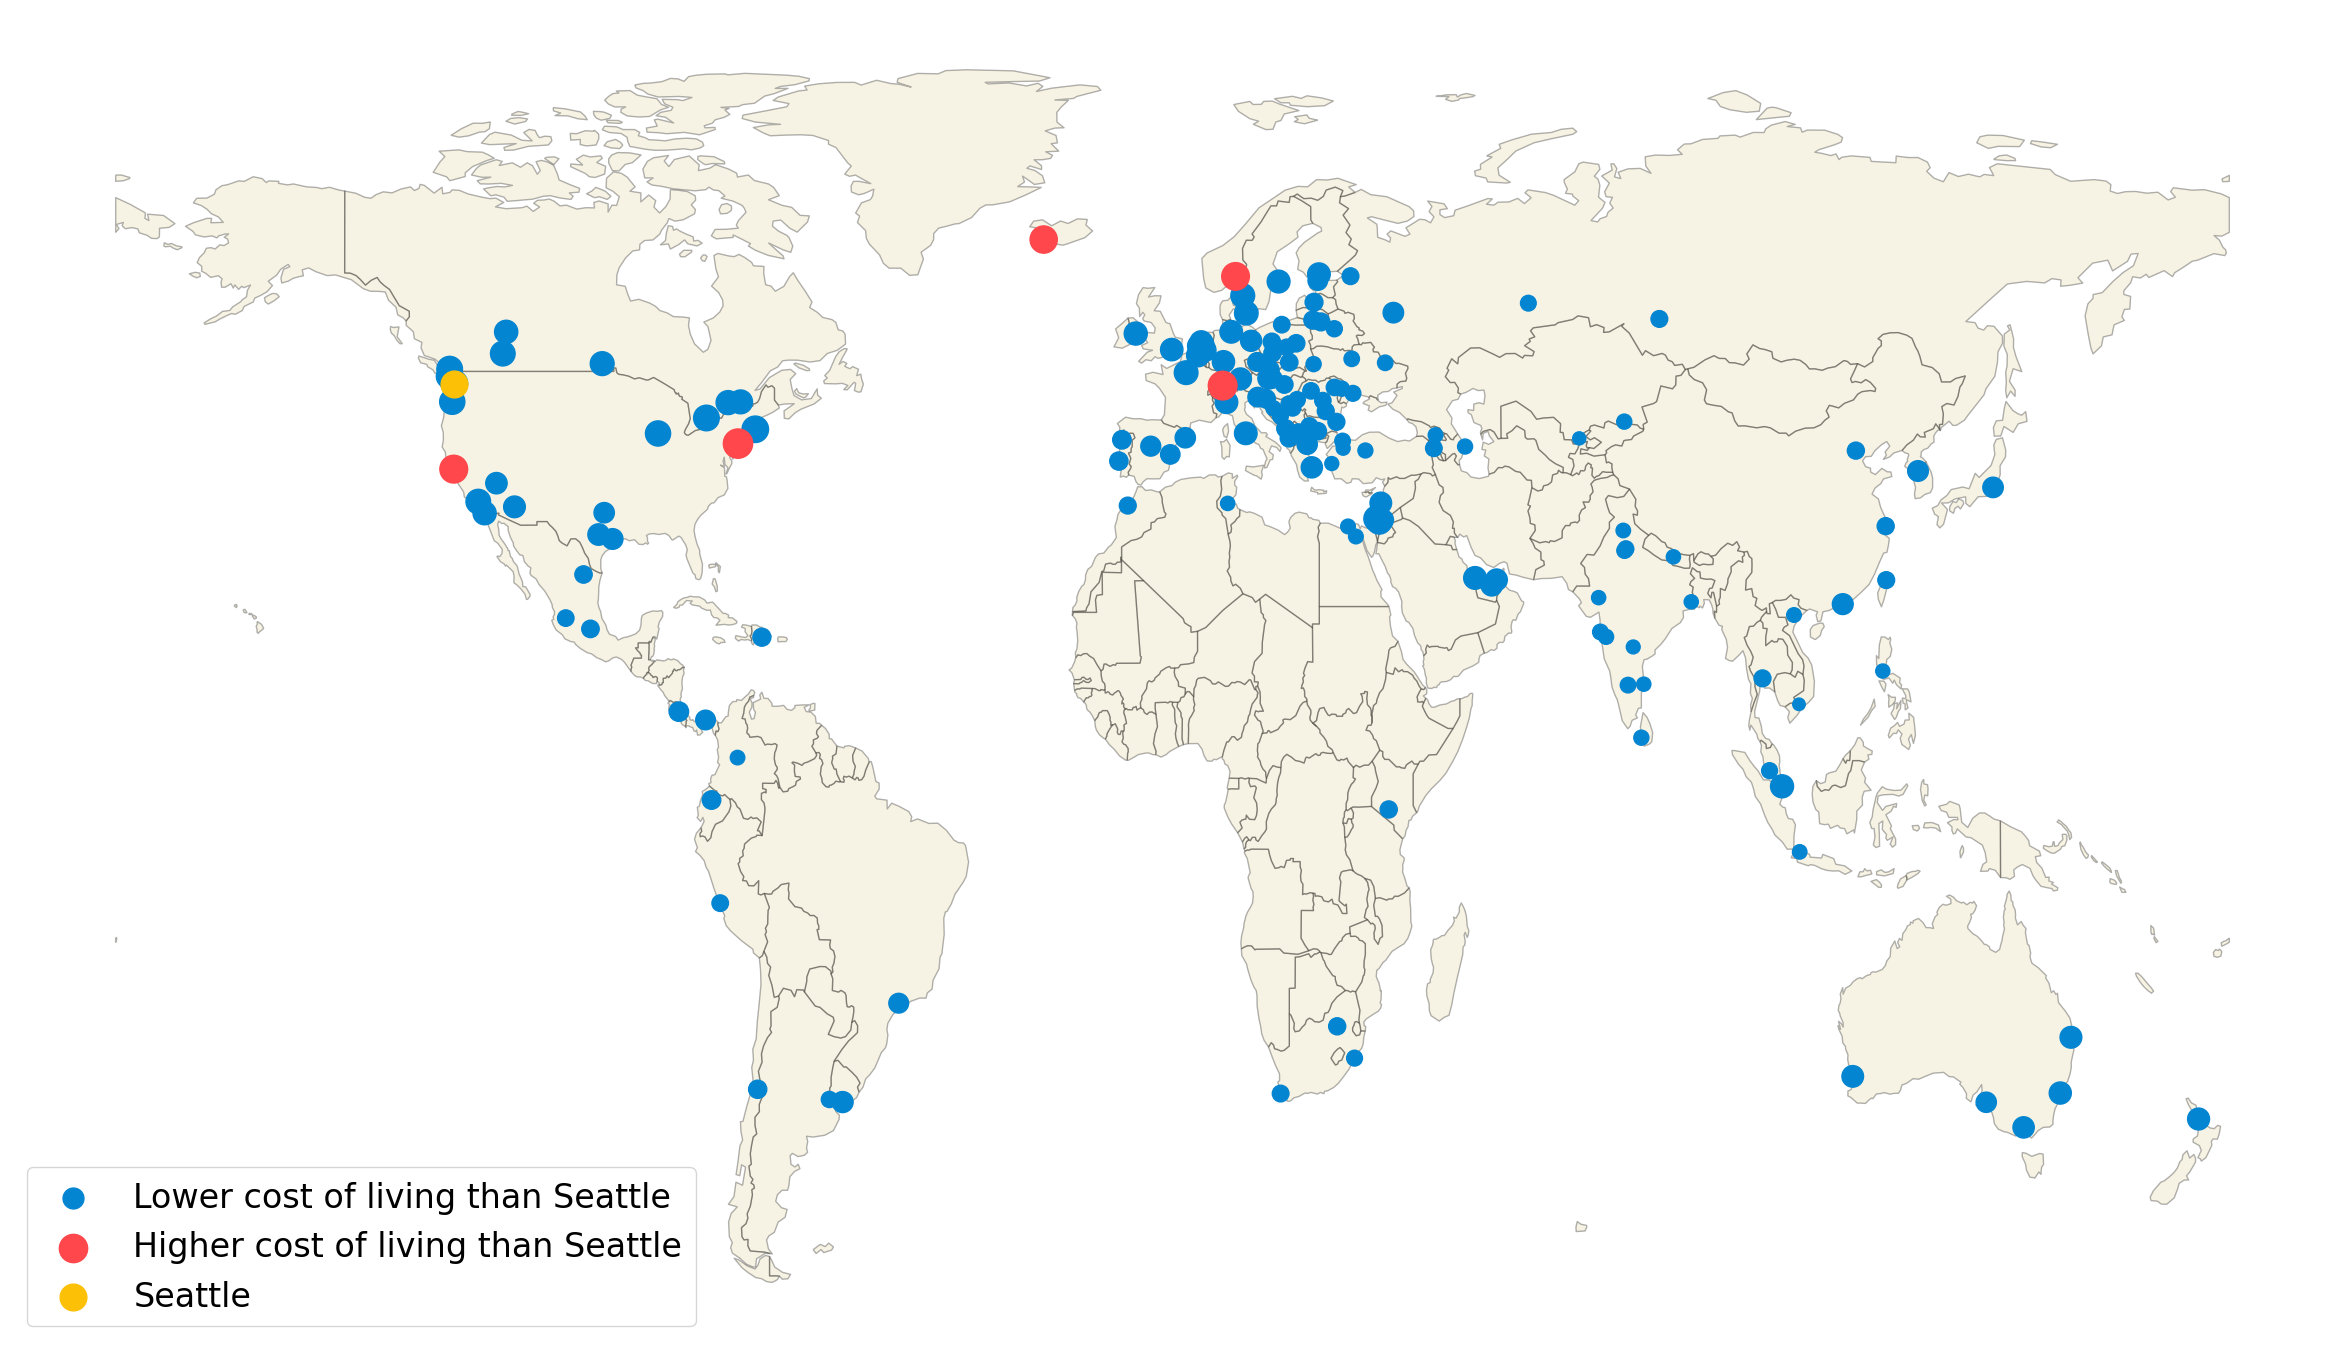

In [7]:
# Calculate the cost of living metric for each city and save Seattle's cost of living in a variable
median_prices = prices.iloc[:,3:].median(axis = 1)
seattle_median = float(median_prices[prices['City'] == 'Seattle'])

# Determine which cities have a lower cost of living than Seattle and which have a higher cost of living
lower_seattle = median_prices <= seattle_median
higher_seattle = median_prices > seattle_median

# Plot each city on the world map with the bubble area proportional to the city's cost of living
base = world.plot(color='xkcd:beige', alpha=0.3, edgecolor='black', figsize=(30, 20))
base.set_axis_off()
geo_df[lower_seattle].plot(ax=base, marker='o', color='xkcd:cerulean', markersize=median_prices[lower_seattle]*30, 
                             label = 'Lower cost of living than Seattle')
geo_df[higher_seattle].plot(ax=base, marker='o', color='xkcd:light red', markersize=median_prices[higher_seattle]*30, 
                            label = 'Higher cost of living than Seattle')
geo_df[geo_df['City'] == 'Seattle'].plot(ax=base, marker='o', color='xkcd:marigold', markersize=seattle_median * 30, 
                                         label = 'Seattle')
plt.legend(prop={'size': 24}, loc = 'lower left')
plt.show()

The bubble map above illustrates that only 5 of the 160 cities have a higher cost of living than Seattle. While Seattle's cost of living is only slightly less than that of the five most expensive cities, it's cost of living is significantly higher than that of the least expensive cities, particularly those in Asia. These findings indicate that a tourist from Seattle will generally experience a similar or slightly lower cost of living when visiting major cities in the US, Canada, Western Europe, and Australia and generally experience a significantly lower cost of living when visiting major cities in Mexico, South America, Africa, Eastern Europe, and Asia.

### Question 2: How does the cost of living in the US compare to other countries around the world?

To compare the cost of living in the various countries, I represented each country's cost of living by the mean cost of living of the cities in that country. The cost of living of each individual city was again represented by the median price of all 55 goods and services in the data set. To ensure that each country's calculated cost of living was representative of multiple major cities in that country, I excluded countries with only one city represented in the data set.

The choropleth map below illustrates the results of the comparison.

/var/folders/pl/n9dpnr6j189_tc7zv1jcdnph0000gn/T/ipykernel_17343/2628749248.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_cost = group.median(axis = 1).mean()
/var/folders/pl/n9dpnr6j189_tc7zv1jcdnph0000gn/T/ipykernel_17343/2628749248.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_cost = group.median(axis = 1).mean()
/var/folders/pl/n9dpnr6j189_tc7zv1jcdnph0000gn/T/ipykernel_17343/2628749248.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_cost = group.m

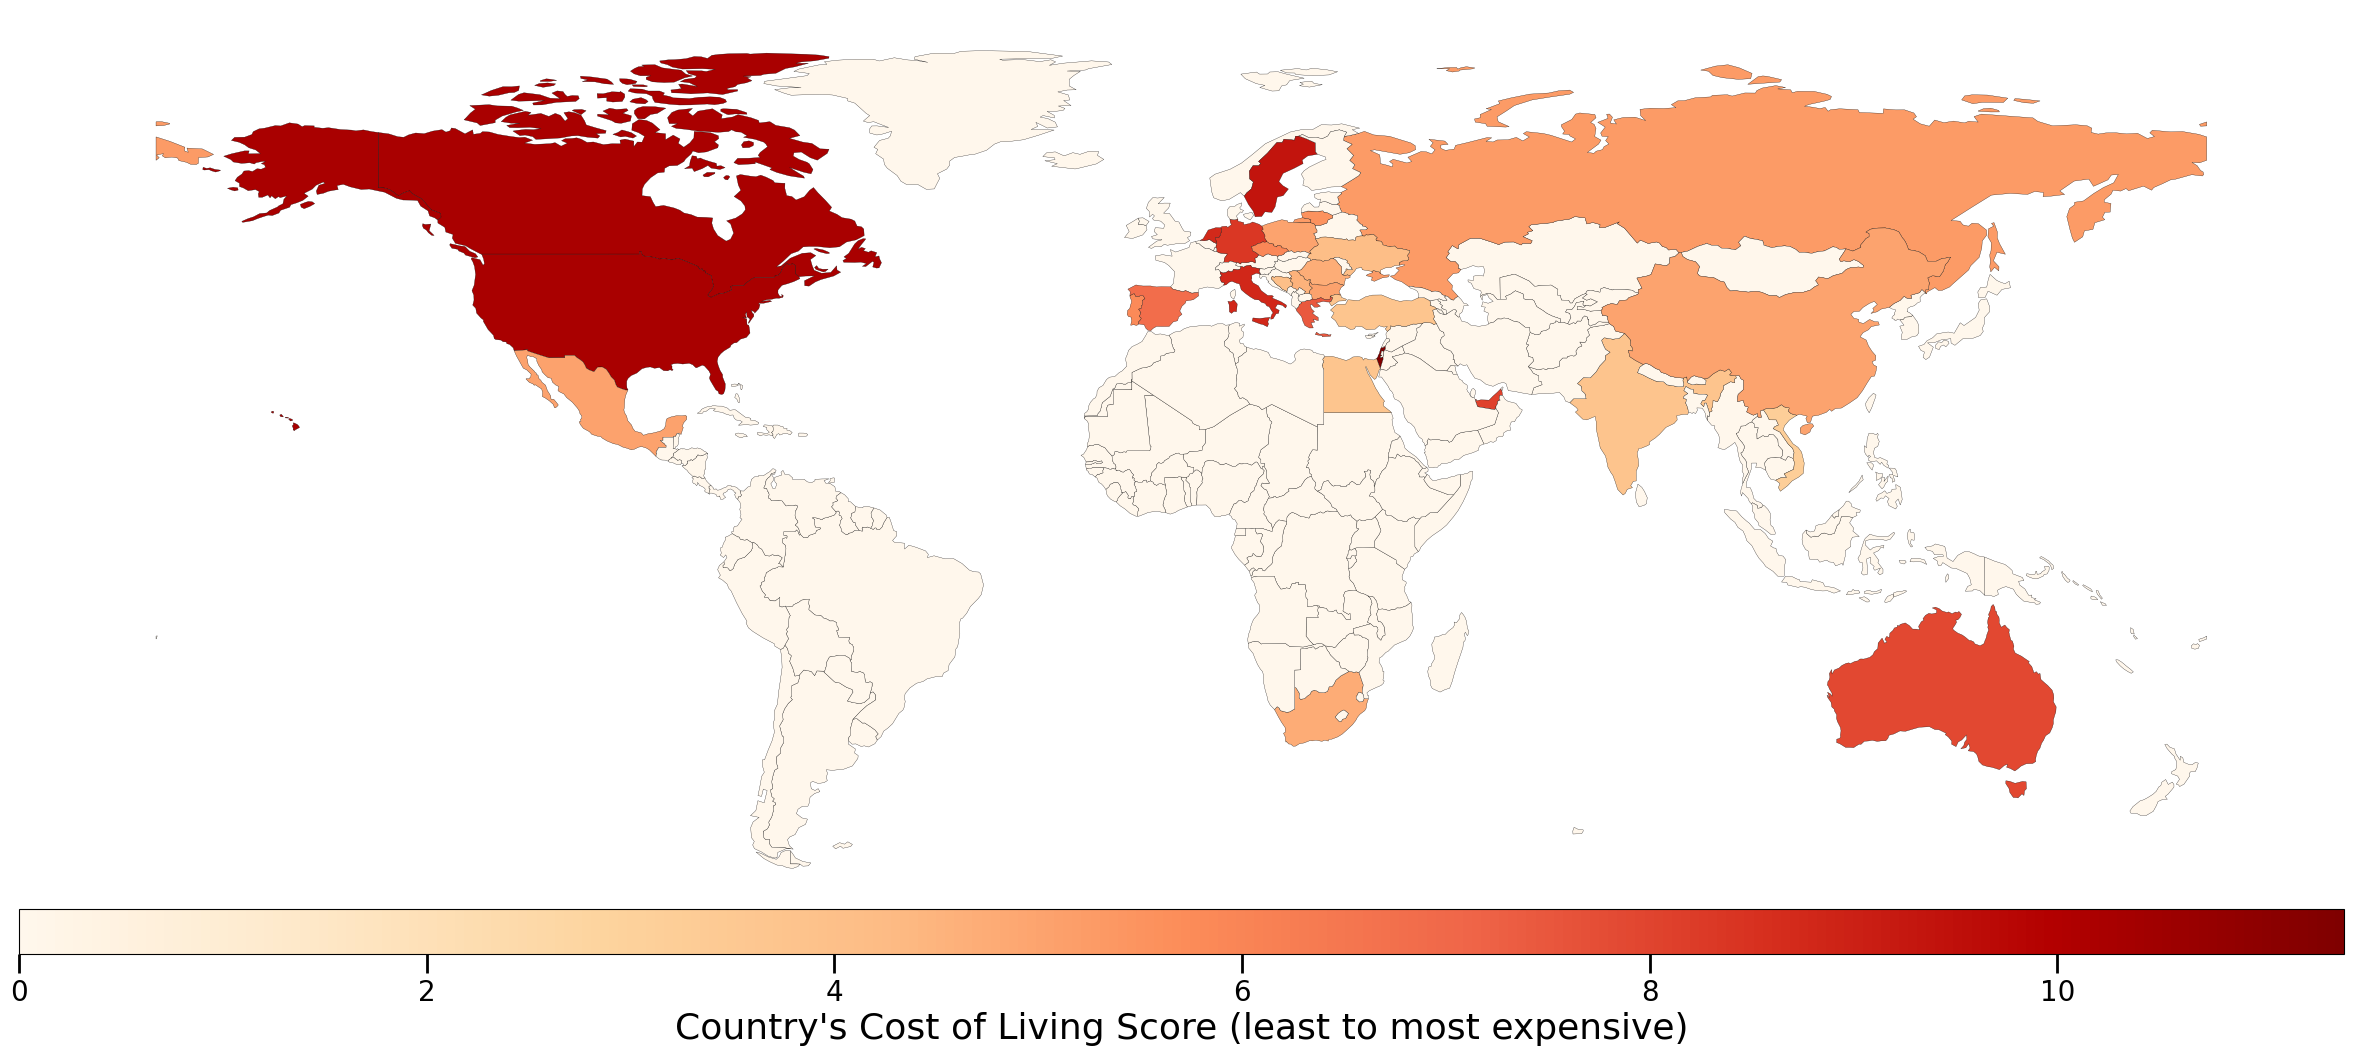

In [8]:
# Import package used to format the choropleth map
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Group the prices DataFrame by country
groups = prices.groupby('Country')

# Add a new column to the world GeoDataFrame to store the mean cost of living of each country
world['cost'] = 0

# For countries with more than two cities in the data set, find the mean cost of living in that country and add 
# it to the world GeoDataFrame
for country, group in groups:
    if len(group) >= 2:
        mean_cost = group.median(axis = 1).mean()

        # Specifically add the mean_cost for countries that are spelled differently in the world GeoDataFrame 
        # than they are in the prices DataFrame. 
        if country == 'United States':
            world.loc[world.name == 'United States of America', 'cost'] = mean_cost
        elif country == 'Bosnia And Herzegovina':
            world.loc[world.name == 'Bosnia and Herz.', 'cost'] = mean_cost
        elif country == 'Czech Republic':
            world.loc[world.name == 'Czechia', 'cost'] = mean_cost
        # Automatically add the mean_cost for all other countries.
        else:
            world.loc[world.name == country, 'cost'] = mean_cost
            
# Create and format the choropleth map
fig, ax = plt.subplots(figsize=(30, 20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0)
choropleth = world.plot(column='cost', ax=ax, legend=True, cax=cax, edgecolor='black', linewidth=0.2, cmap='OrRd', 
                        legend_kwds={'label': "Average Cost of Living", 'orientation': "horizontal"}, vmin=0)
choropleth.set_axis_off()
plt.tick_params(labelsize=20, length=14, width=2)
cax.set_xlabel("Country's Cost of Living Score (least to most expensive)", fontsize=26)
plt.show()

From the choropleth map above, it is clear that the cost of living in major cities in the United States is generally higher than in most other countries. In fact, the only countries with a higher cost of living in the data set were Israel and Canada. 

### Question 3: What are the most uniformly priced goods and services?

Next, I determined which goods and services had the most stable price and which had the most variable price across the 160 cities in the data set. The price variation of each item was represented by the coefficient of variation of that item's price across the 160 cities. i.e., the standard deviation of that item's price divided by the mean of that item's price. I quantified price variability using the coefficient of variation rather than the standard deviation because the coefficient of variation is a normalized form of the standard deviation that allows one to compare the standard deviations of data samples on different scales. In this case, the coefficient of variation allowed me to meaningfully compare the price variability between both cheap and expensive items, whereas the standard deviation would have misleadingly magnified the price variability of expensive items simply because their prices have a larger magnitude.

The bar chart below presents the results of this price variability analysis.

/var/folders/pl/n9dpnr6j189_tc7zv1jcdnph0000gn/T/ipykernel_17343/2156705166.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  var = (prices.iloc[:,3:].std(axis = 0) / prices.iloc[:,3:].mean(axis = 0)).sort_values(ascending=False)


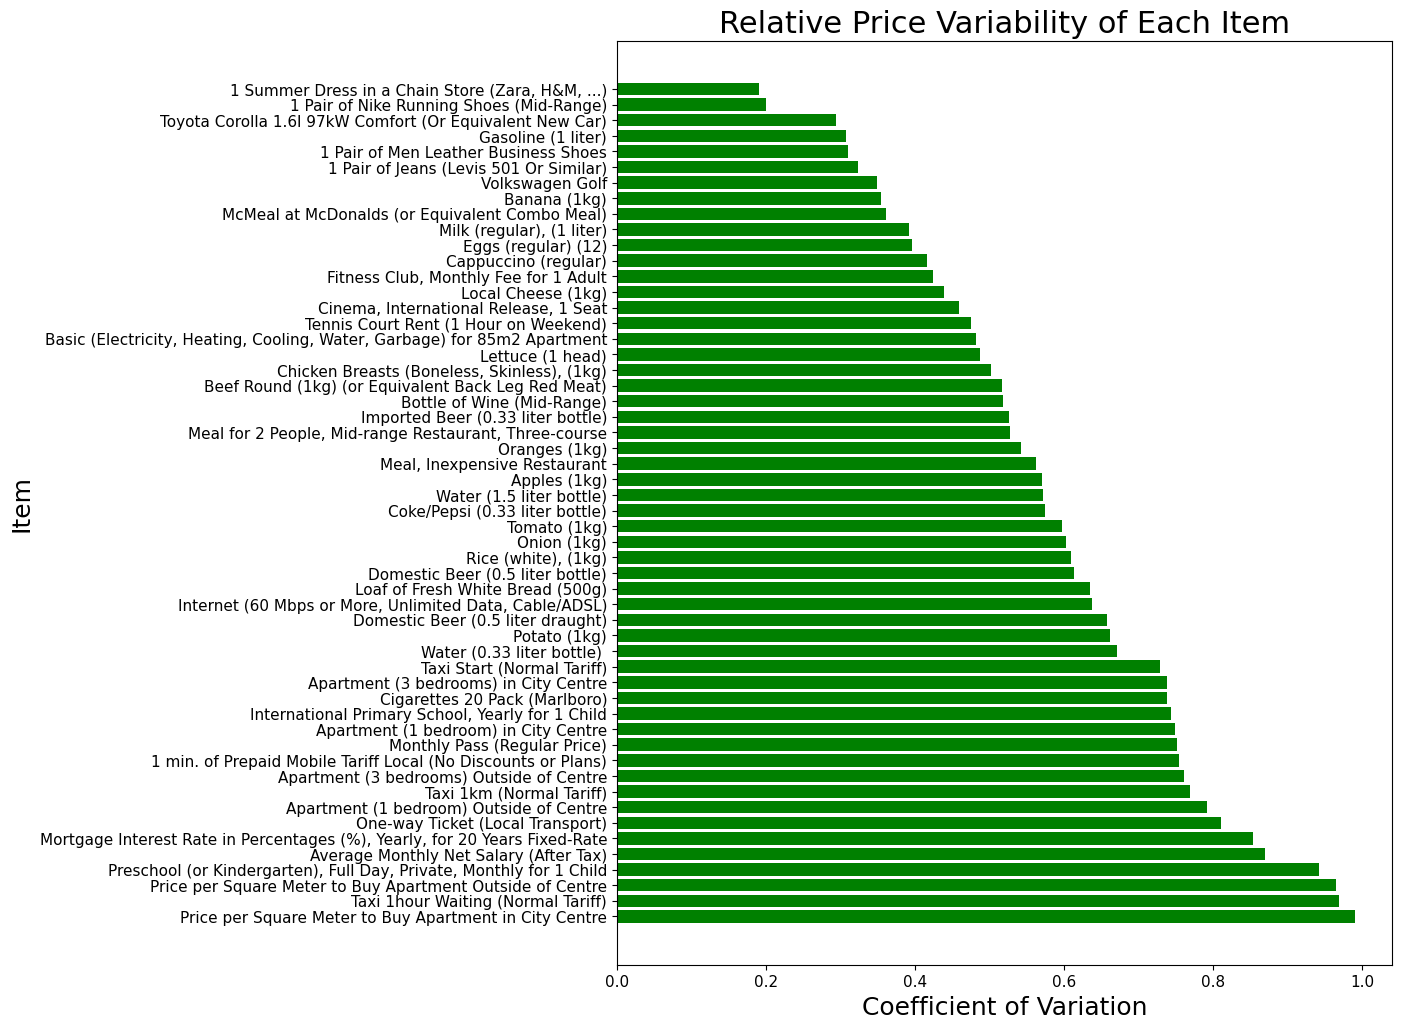

In [9]:
# Calculate the coefficient of variation for each item
var = (prices.iloc[:,3:].std(axis = 0) / prices.iloc[:,3:].mean(axis = 0)).sort_values(ascending=False)

# Create a horizontal bar chart showing the coefficient of variation of each item
plt.figure(figsize=(10,12))
plt.barh(var.index, var, color='g')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel('Coefficient of Variation', fontsize = 18)
plt.ylabel('Item', fontsize = 18)
plt.title('Relative Price Variability of Each Item', fontsize = 22)
plt.show()

The bar chart above indicates that clothing and automotive items have the most uniform price while housing and transportation items have the most variable price. These findings are fairly intuitive as clothes and cars have intrinsic value whereas the value of housing and transportation is largely determined by the city in which they are provided, with more densely populated cities generally having higher housing and transportation costs.

### Question 4: Which  goods and services are the most correlated in price?
    
Finally, I examined the correlation between the goods and services in terms of price. Specifically, I determined which items were the most positively correlated, which were the most negatively correlated, and which exhibited no discernible correlation.

To quantify the degree of correlation between items, I used the correlation coefficient, r. The correlation coefficient can assume values between -1 and 1, with -1 indicating a perfectly negative linear correlation and 1 indicating a perfectly positive linear correlation.

The heat map below is a visual representation of the correlation matrix for the 55 items. Each cell in the heat map corresponds to a pair of items and the color of each cell indicates the correlation coefficient for that pair of items.

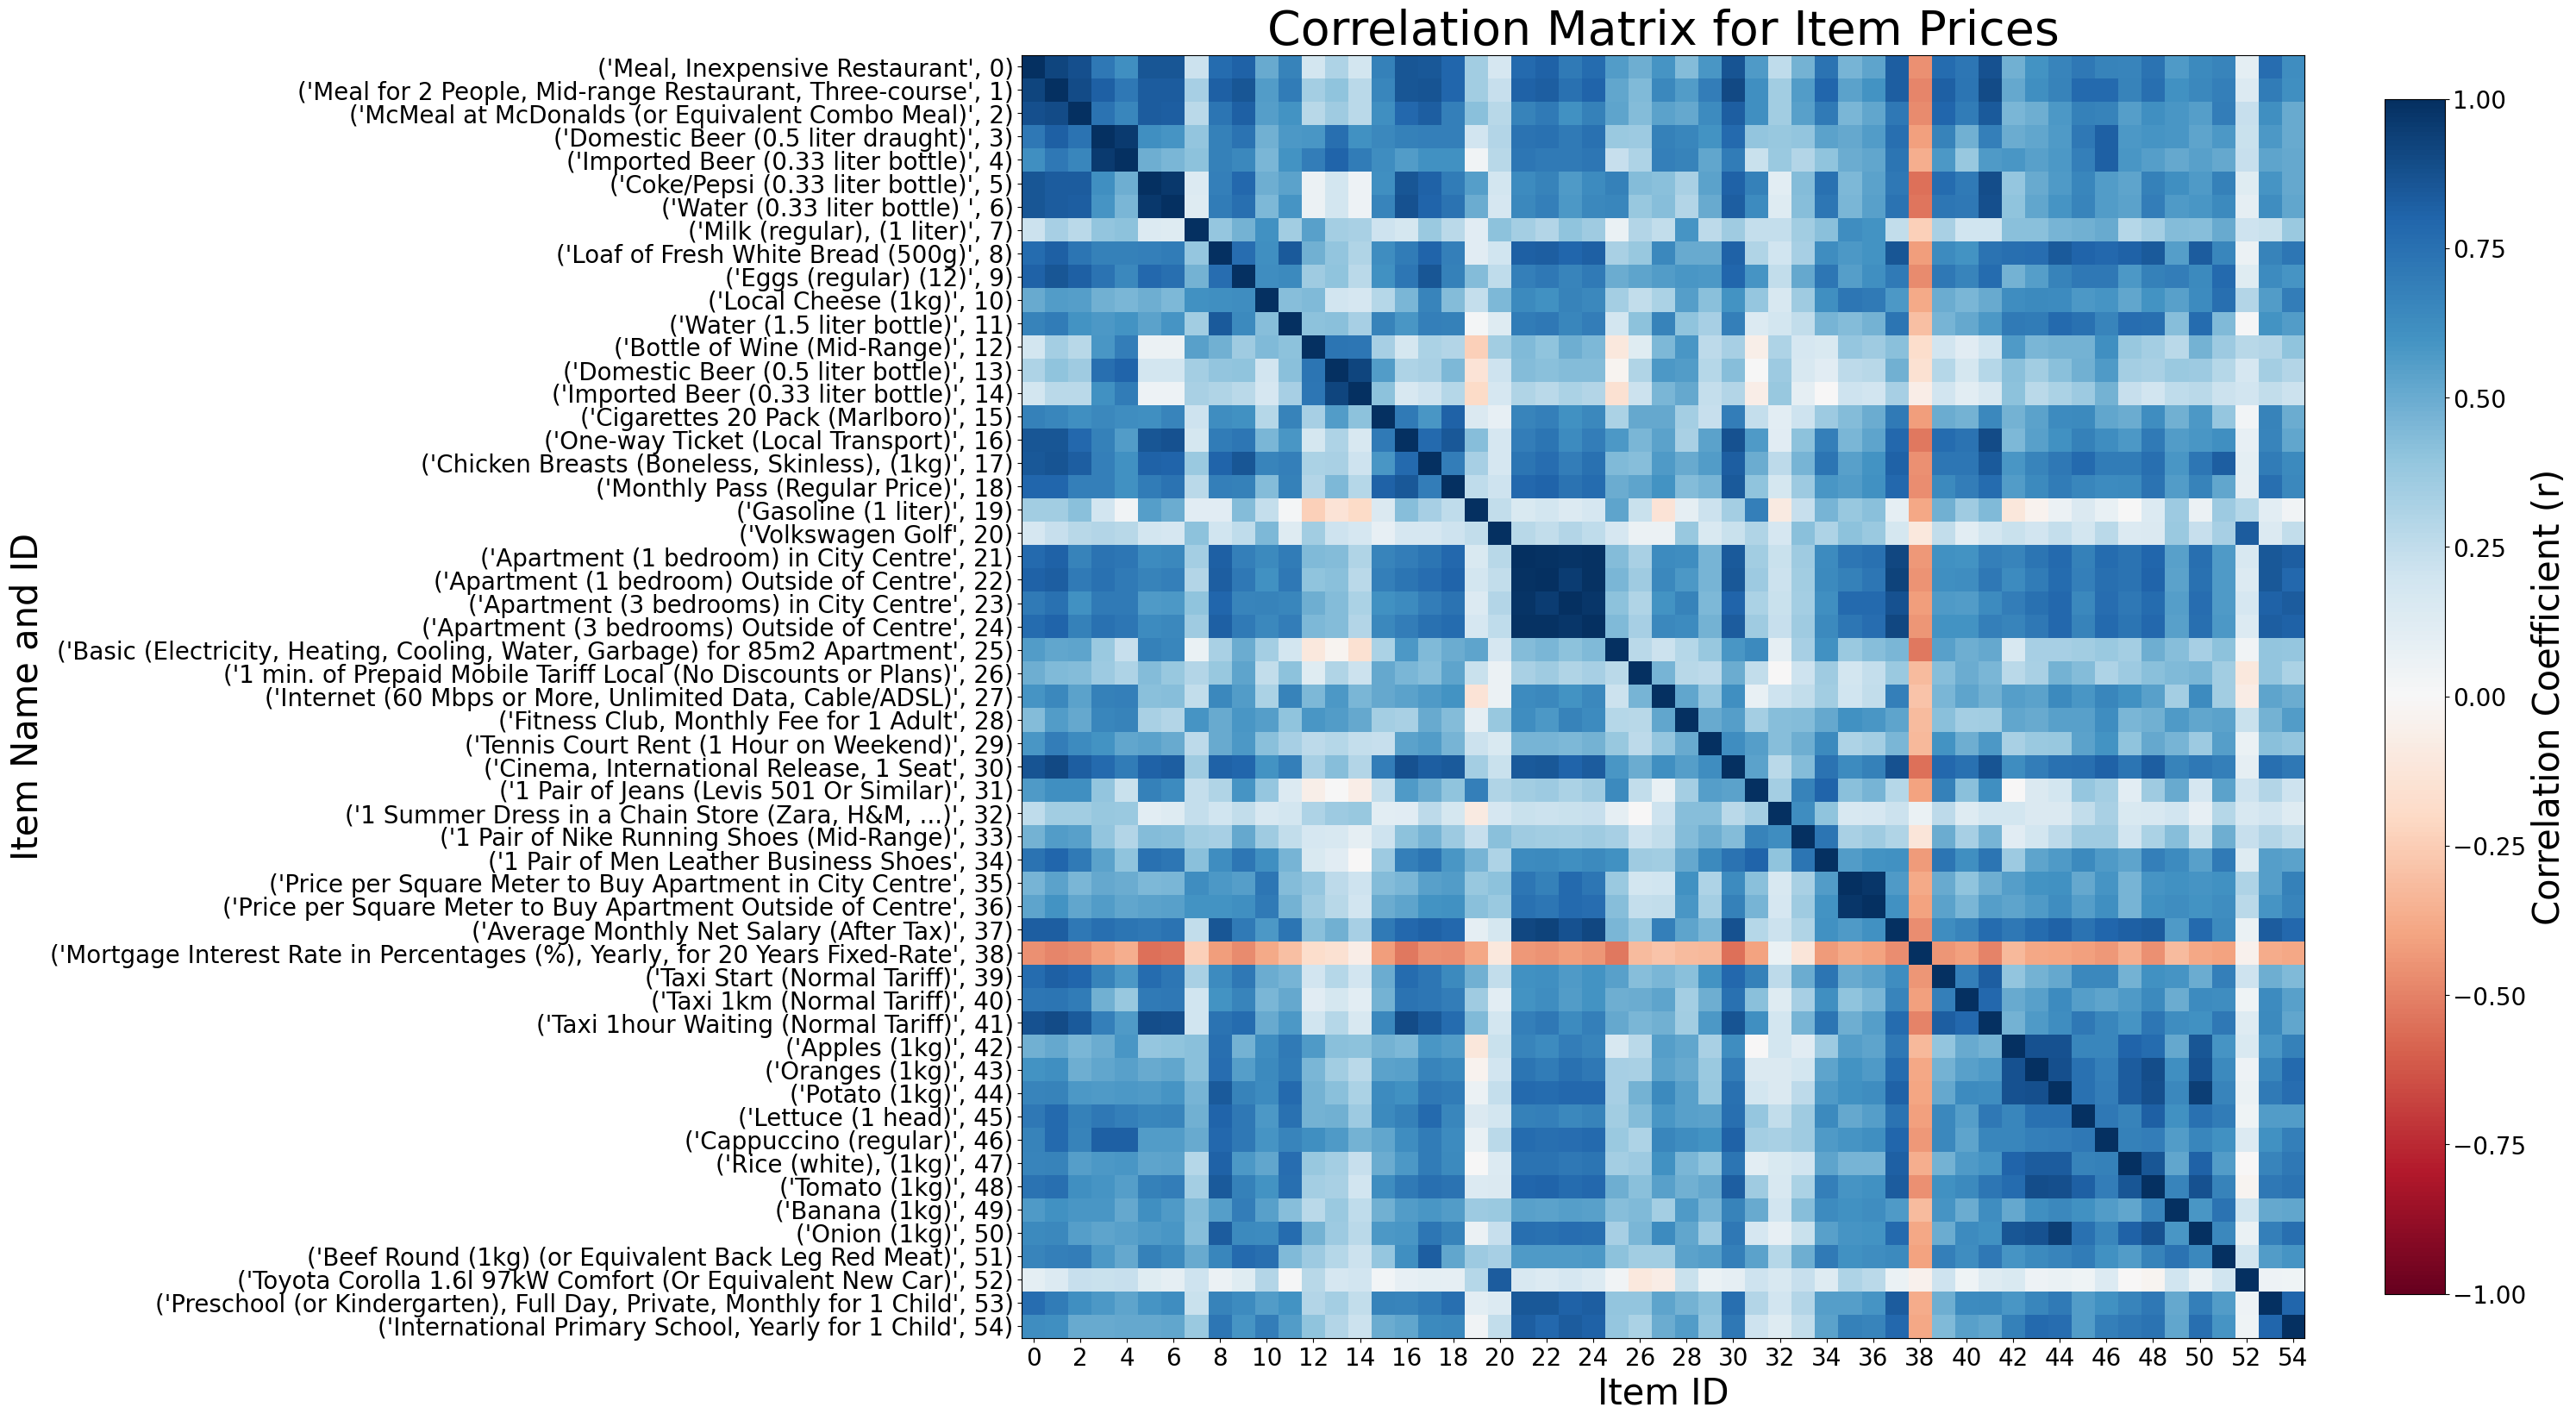

In [10]:
# Select only the columns from the prices DataFrame that correspond to goods and services
items_only = prices.iloc[:,3:58]

# Create and format a correlation heatmap for the item prices across the 160 cities
fig, ax = plt.subplots(figsize=(24, 24))
img = ax.matshow(items_only.corr(), cmap='RdBu', vmin=-1, vmax=1)

plt.xticks(range(0,len(items_only.columns),2), ha='center')
plt.yticks(range(0,len(items_only.columns),1), zip(items_only.columns, items_only.index))
ax.xaxis.set_ticks_position('bottom')
plt.tick_params(labelsize=20)

plt.xlabel('Item ID', fontsize=30)
plt.ylabel('Item Name and ID', fontsize=30)
plt.title('Correlation Matrix for Item Prices', fontsize=40)

# Create and format the color bar legend
cb = plt.colorbar(img, shrink = 0.75)
cb.ax.tick_params(labelsize=20)
cb.ax.set_ylabel("Correlation Coefficient (r)", fontsize=30)

# Display the heat map
plt.show()

From the heat map above, it is clear that the vast majority of the goods and services exhibit moderate to strong positive correlation with each other, i.e., as the price of one item increases, the prices of other items generally increase as well. This is an intuitive result, as we would expect the price of most goods and services to increase as the overall cost of living of a city increases.

Of the item pairs that exhibited the strongest positive correlation, some were correlated for obvious reasons. For example, the strong positive correlation between items 35 and 36 is fairly predictable, as the items represent the price per square meter to buy an apartment in the city center and outside of the city center, respectively.

However, some of the strongest positive correlations were between items that were seemingly unrelated. For instance, there was a strong positive correlation between the prices of item 1, a three-course meal for two at a mid-range restaurant, and item 30, a movie theater ticket. This correlation is illustrated in the scatter plot below.

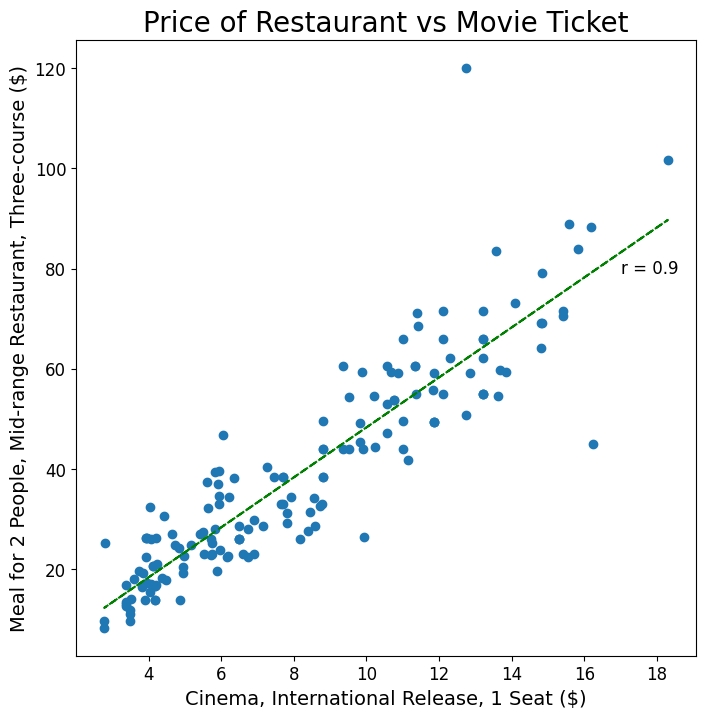

In [11]:
# Import package used to create line of best fit
import numpy as np

# Specify which two items are being plotted against each other
item1 = 30
item2 = 1
x_data = items_only.iloc[:,item1]
y_data = items_only.iloc[:,item2]

# Create and format the scatter plot
plt.figure(figsize=(8,8))
plt.scatter(x_data, y_data)
plt.xlabel(items_only.columns[item1] + ' ($)', fontsize = 14)
plt.ylabel(items_only.columns[item2] + ' ($)', fontsize = 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Price of Restaurant vs Movie Ticket', fontsize=20);

# Plot line of best fit and value of correlation coefficient
plt.plot(x_data, np.poly1d(np.polyfit(x_data, y_data, 1))(x_data), '--g')
plt.text(17, 79, 'r = ' + str(round(items_only.iloc[:,[item1,item2]].corr().iloc[0,1], 2)), fontsize=12)

# Display the scatter plot
plt.show()

The scatter plot above shows that as the price of a movie ticket increases, the price of a three-course meal at a restaurant increases relatively linearly. This strong positive correlation may be explained by the fact that these items are evening activities that are commonly paired together. As many people go to a restaurant and watch a movie on the same night, the prices of these two services may have become correlated over time.

Another interesting finding revealed by the heat map is that the only item that is almost always negatively correlated with the other items in the data set is item 38, the mortgage interest rate. The scatter plot below illustrates the relationship between the mortgage interest rate and the rental price of an apartment.

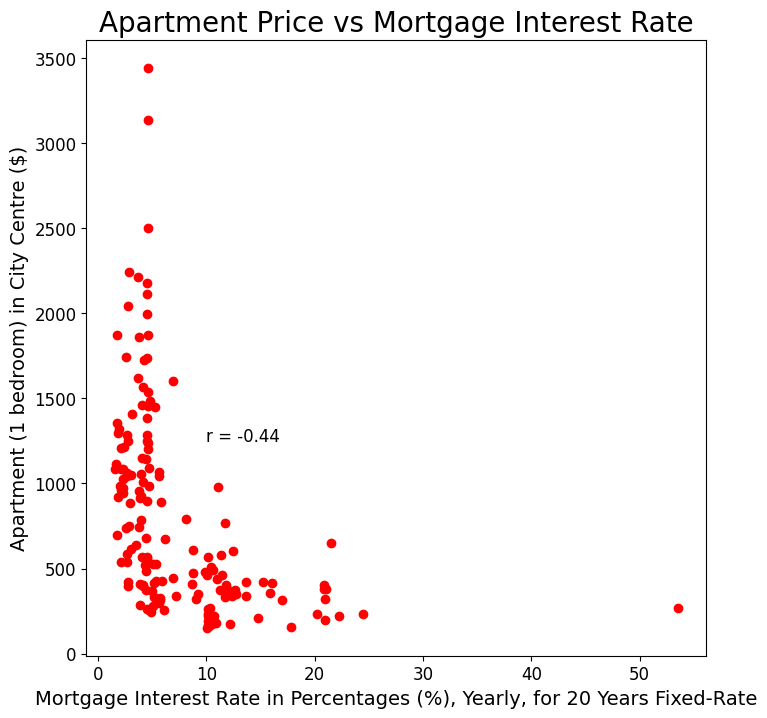

In [12]:
# Specify which two items are being plotted against each other
item1 = 38
item2 = 21
x_data = items_only.iloc[:,item1]
y_data = items_only.iloc[:,item2]

# Create and format the scatter plot
plt.figure(figsize=(8,8))
plt.scatter(x_data, y_data, c='r')
plt.xlabel(items_only.columns[item1], fontsize = 14)
plt.ylabel(items_only.columns[item2] + ' ($)', fontsize = 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.text(10, 1250, 'r = ' + str(round(items_only.iloc[:,[item1,item2]].corr().iloc[0,1], 2)), fontsize=12)
plt.title('Apartment Price vs Mortgage Interest Rate', fontsize=20);

# Display the scatter plot
plt.show()

In the scatter plot above, we see that cities with high-priced apartments have a relatively low mortgage interest rate. As the typical rental price for an apartment decreases from 3,500 to 1,000 USD, the mortgage interest rate remains relatively low. However, when the rental price decreases below 1,000 USD, the mortgage interest rate increases at an increasing rate. Thus, while the relationship between apartment rental price and mortgage interest rate is not linear, there is a clear negative correlation between these two items. A likely explanation for this negative correlation is that cities with lower-priced apartments are usually struggling economically and are at greater risk for loan defaults, resulting in these cities having higher mortgage interest rates.

Finally, the heat map also reveals that there are a few items that exhibit no significant correlation with the other items. One example that is clearly visible in the heat map is item 52, the Toyota Corolla. The scatter plot below illustrates the relationship between the price of a Toyota Corolla and the price of an apartment.

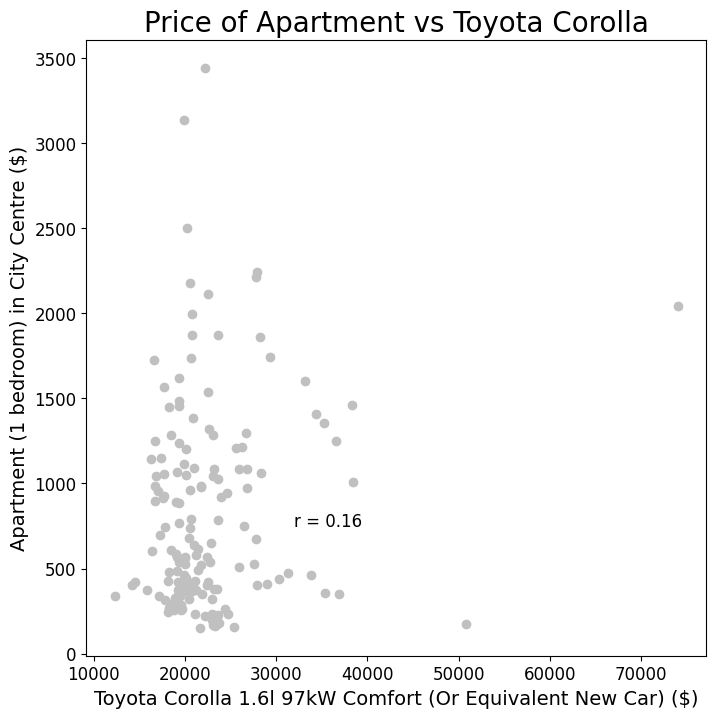

In [13]:
# Specify which two items are being plotted against each other
item1 = 52
item2 = 21
x_data = items_only.iloc[:,item1]
y_data = items_only.iloc[:,item2]

# Create and format the scatter plot
plt.figure(figsize=(8,8))
plt.scatter(x_data, y_data, c='silver')
plt.xlabel(items_only.columns[item1] + ' ($)', fontsize = 14)
plt.ylabel(items_only.columns[item2] + ' ($)', fontsize = 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.text(32000, 750, 'r = ' + str(round(items_only.iloc[:,[item1,item2]].corr().iloc[0,1], 2)), fontsize=12)
plt.title('Price of Apartment vs Toyota Corolla', fontsize=20);

# Display the scatter plot
plt.show()

The scatter plot above illustrates that with a correlation coefficient of 0.16, the relationship between the price of a Toyota Corolla and the price of an apartment exhibits no significant correlation. This result is not surprising, as the Toyota Corolla had the third most uniform price among the items in the data set, indicating that its price is largely unaffected by the price of other goods and services. 

## Data Analysis in Tableau

Finally, I repeated the entire analysis in Tableau to practice using Tableau's data visualization tools.

All of the data visualizations above were recreated in Tableau and are presented in the Tableau story embedded below. For optimal viewing, click on the "Full Screen" icon at the lower right corner of the embedded view. 

In [14]:
%%HTML
<! –– Embed the Tableau story ––>

<div class='tableauPlaceholder' id='viz1581455146967' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Da&#47;DataAnalysisProject_15813632756150&#47;DataAnalysisProject&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='DataAnalysisProject_15813632756150&#47;DataAnalysisProject' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Da&#47;DataAnalysisProject_15813632756150&#47;DataAnalysisProject&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1581455146967');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>